# Real-time Anomaly Detection Playground

Dataset used: [AnoML-IoT](https://www.kaggle.com/datasets/hkayan/anomliot)

Sample dataset format:

| Time       | Temperature | Humidity | ... |
|------------|-------------|----------|-----|
| 1623781306 | 37.94       | 28.94    | ... |
| ...        | ...         | ...      | ... |

Although the data is unlabelled, it was stated in the description of the dataset that anomalies are created in the following period of time:

- 18:21:46 - 19:37:16 (first day)
- 02:26:36 - 04:15:56 (second day)
- 08:54:46 - 10:45:36 (second day)

## Load Dataset

In [1]:
import pandas as pd

anoml_iot_dataset = pd.read_csv("./datasets/dataset_final.csv")

# Selecting the date range to be used for training and testing
anoml_iot_dataset = anoml_iot_dataset[anoml_iot_dataset["Time"] > 1623787200]
record_count = anoml_iot_dataset.shape[0]
print(f"Total number of records: {record_count}")

Total number of records: 5968


## Generate Ground Truth

In [2]:
def is_data_point_anomaly(row):
    # 18:21:46 - 19:37:16 (first day)
    if 1623781306 <= row["Time"] <= 1623785836:
        return 1
    # 02:26:36 - 04:15:56 (second day)
    if 1623810396 <= row["Time"] <= 1623816956:
        return 1
    # 08:54:46 - 10:45:36 (second day)
    if 1623833686 <= row["Time"] <= 1623840336:
        return 1
    return 0


ground_truth = []
for _, row in anoml_iot_dataset.iterrows():
    ground_truth.append(is_data_point_anomaly(row))

## Plot Data

/tmp/ipykernel_19729/1636719805.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


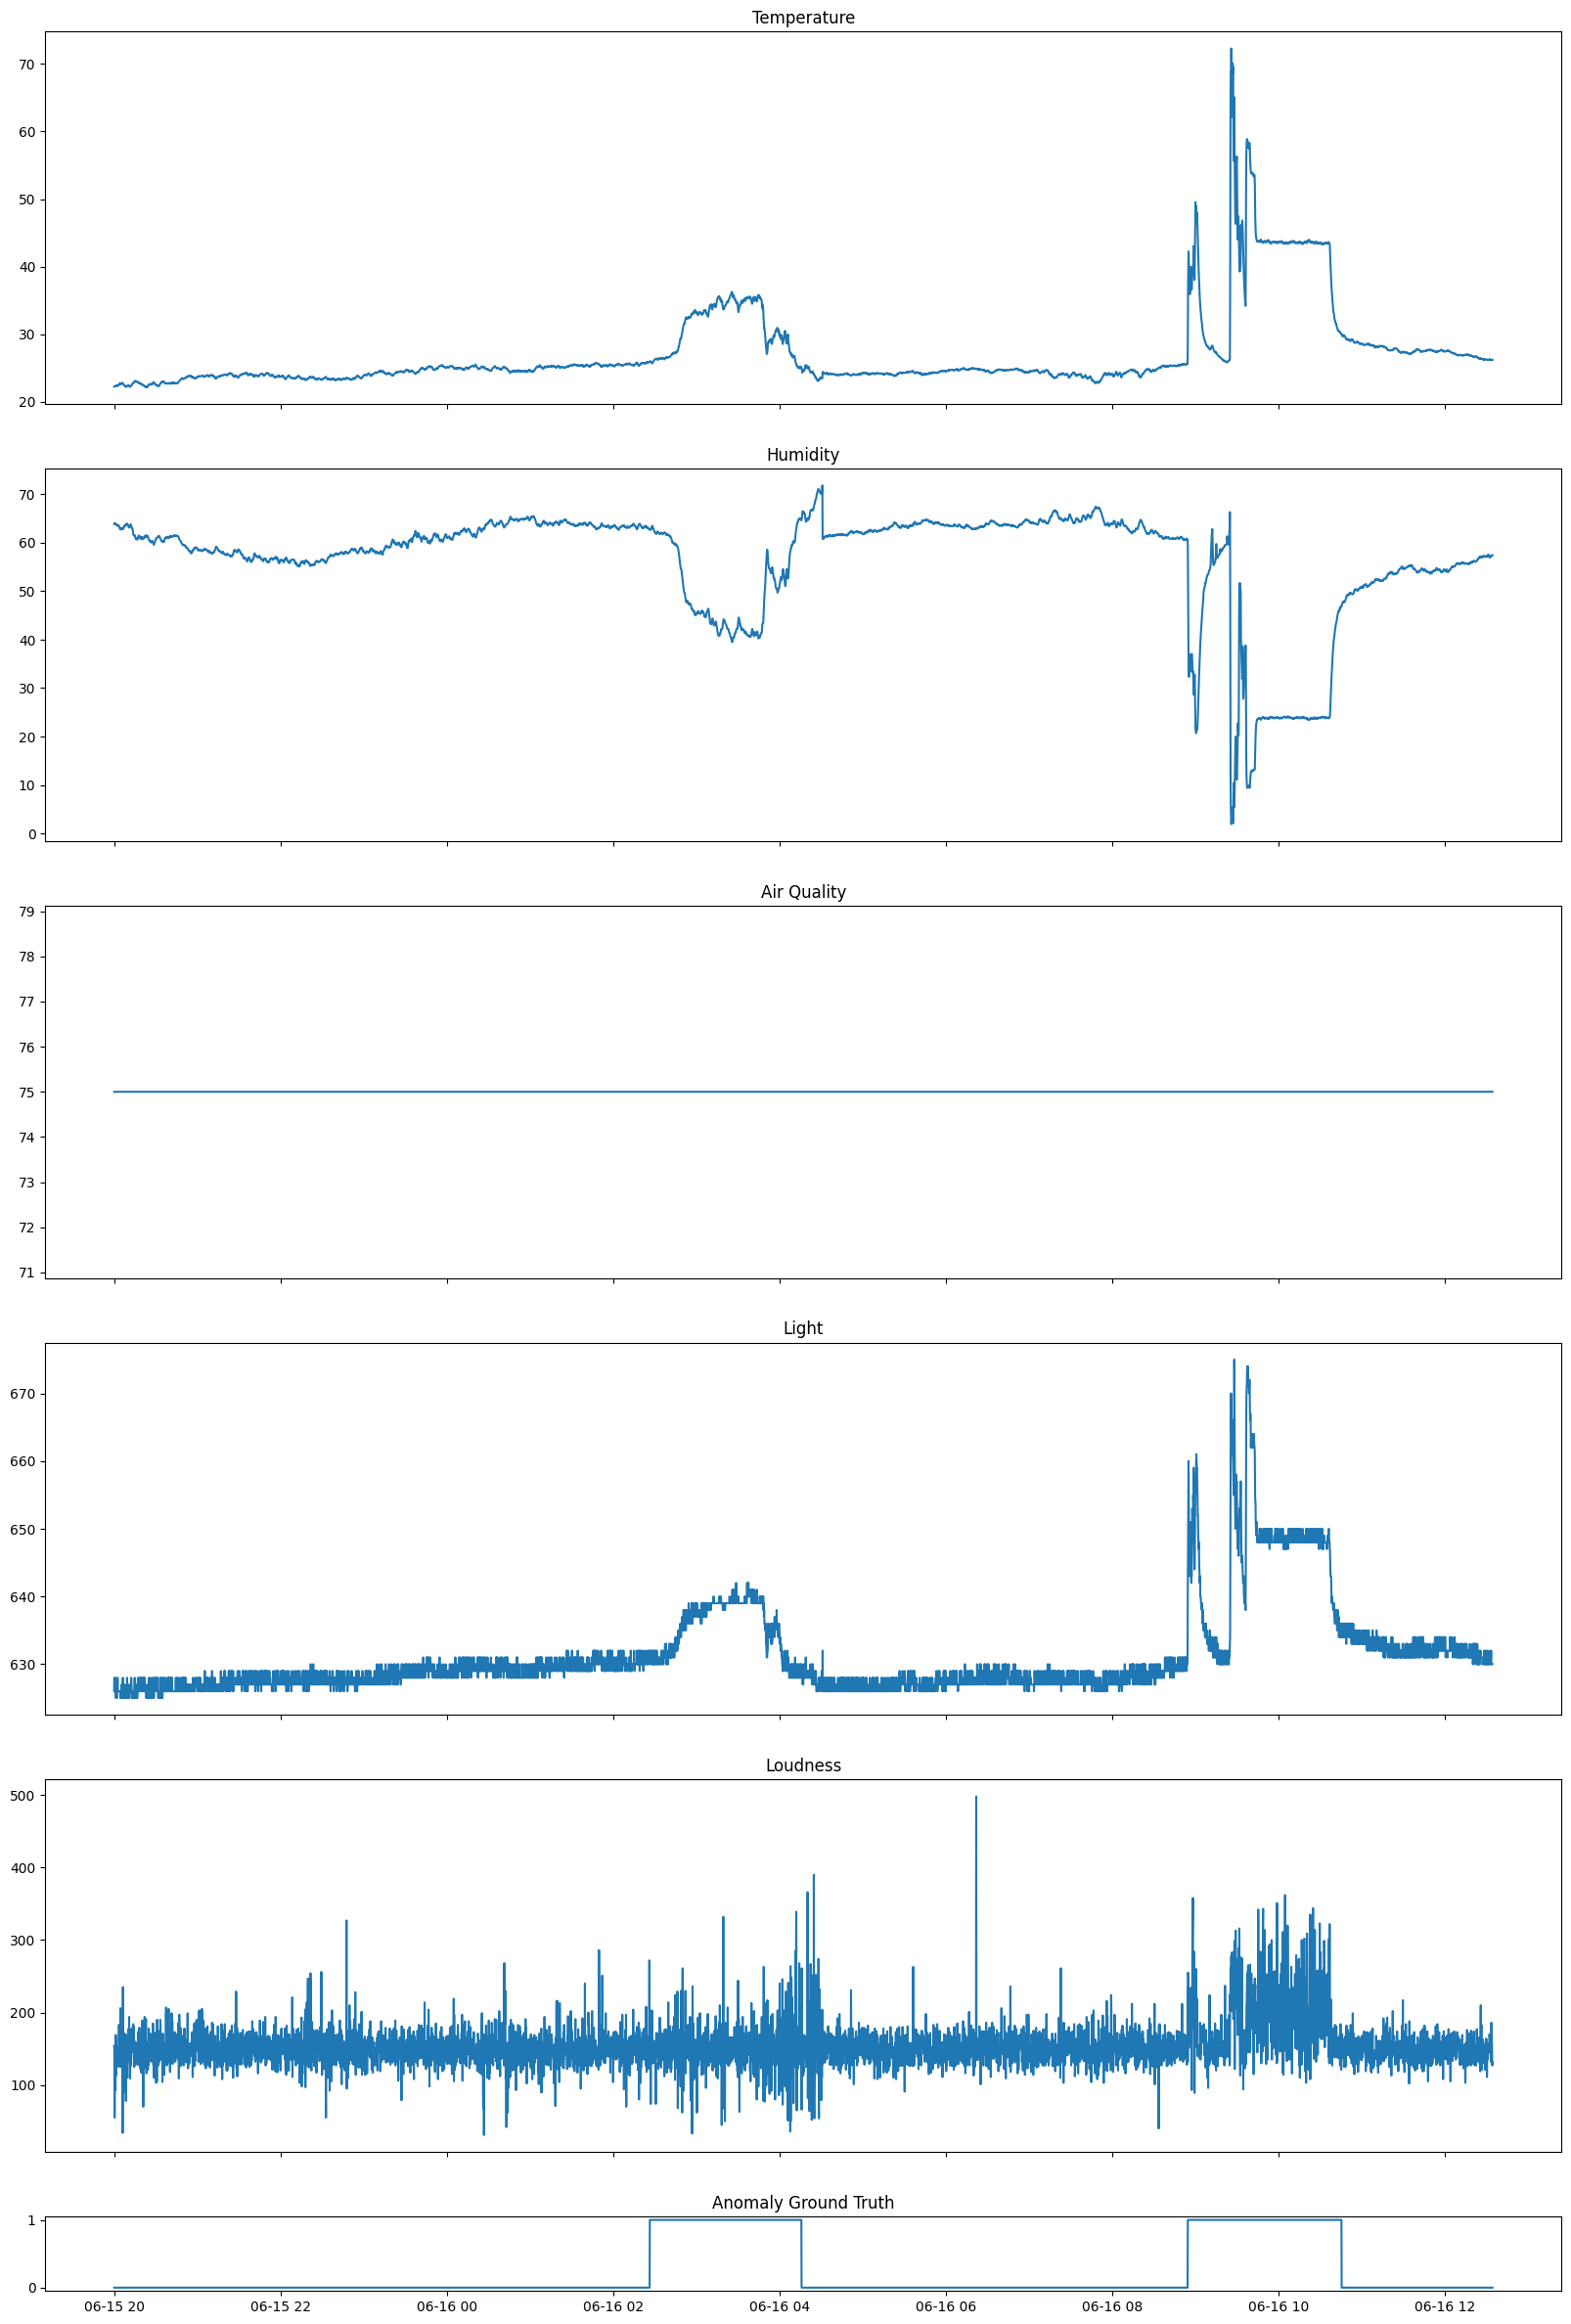

In [3]:
import matplotlib.pyplot as plt

timestamps = pd.to_datetime(anoml_iot_dataset["Time"], unit="s", origin="unix")

fig, ax = plt.subplots(
    6,
    1,
    figsize=(20, 30),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 5, 5, 5, 5, 1]},
)
ax[0].set_title("Temperature")
ax[0].plot(timestamps, anoml_iot_dataset["Temperature"], label="Temperature")
ax[1].set_title("Humidity")
ax[1].plot(timestamps, anoml_iot_dataset["Humidity"], label="Humidity")
ax[2].set_title("Air Quality")
ax[2].plot(timestamps, anoml_iot_dataset["Air Quality"], label="Air Quality")
ax[3].set_title("Light")
ax[3].plot(timestamps, anoml_iot_dataset["Light"], label="Light")
ax[4].set_title("Loudness")
ax[4].plot(timestamps, anoml_iot_dataset["Loudness"], label="Loudness")
ax[5].set_title("Anomaly Ground Truth")
ax[5].plot(timestamps, ground_truth, label="Anomaly Ground Truth")

fig.show()

## Function to convert numeric threshold to binary output

In [4]:
import math


def get_decision_by_threshold(x, upper=math.inf, lower=-math.inf):
    return 1 if x > upper or x < lower else 0

# Evaluating Different Models

> **Assumption:** No data present in the system initially for training the model. The model is trained as the data arrived (online learning approach).

Evaluate method:
- "Temperature", "Humidity" and "Light" are used from the dataset.
- They are all treated as individual data stream (univariate data).
- Initiate `defaultdict` for storing model for each data stream.
- Simulating real-time AD by fitting and scoring data point one by one, then apply a threshold to the anomaly score to compute the binary output.
- Compare the AD result from model to the ground truth, compute the accuracy score

In [5]:
ts_column_to_be_used = ["Temperature", "Humidity", "Light"]

## Exact-STORM

`pysad.models.ExactStorm`

### Model Training and Prediction

In [6]:
from collections import defaultdict

exact_storm_ts_values = defaultdict(list)
exact_storm_scores = defaultdict(list)
exact_storm_results = defaultdict(list)

In [7]:
from collections import defaultdict
from pysad.models import ExactStorm
import numpy as np
import multiprocessing
import time

UPPER_THRESHOLD = 0.6

exact_storm_model_map = defaultdict(lambda: ExactStorm(window_size=400, max_radius=0.4))


def learning_and_detecting_anomaly(ts_column):
    values = []
    scores = []
    results = []

    start_time = time.time()

    for _, row in anoml_iot_dataset.iterrows():
        ts_value = row[ts_column]
        features = np.array([ts_value])
        score = exact_storm_model_map[ts_column].fit_score_partial(features)
        scores.append(score)
        result = get_decision_by_threshold(score, upper=UPPER_THRESHOLD)
        values.append(ts_value)
        results.append(result)

    end_time = time.time()
    print(
        (
            f"[Performance of {ts_column}]\n"
            f"Time taken for all record (s): {{:.5f}}\n"
            f"Avg time taken for each (s)  : {{:.10f}}\n"
        ).format(end_time - start_time, (end_time - start_time) / record_count)
    )

    return values, scores, results


pool = multiprocessing.Pool(processes=3)
results = pool.map(learning_and_detecting_anomaly, ts_column_to_be_used)

for i, column in enumerate(ts_column_to_be_used):
    (
        exact_storm_ts_values[column],
        exact_storm_scores[column],
        exact_storm_results[column],
    ) = results[i]

[Performance of Humidity]
Time taken for all record (s): 0.56462
Avg time taken for each (s)  : 0.0000946077

[Performance of Temperature]
Time taken for all record (s): 0.57847
Avg time taken for each (s)  : 0.0000969293

[Performance of Light]
Time taken for all record (s): 0.59593
Avg time taken for each (s)  : 0.0000998537



### Anomaly Detection Scores

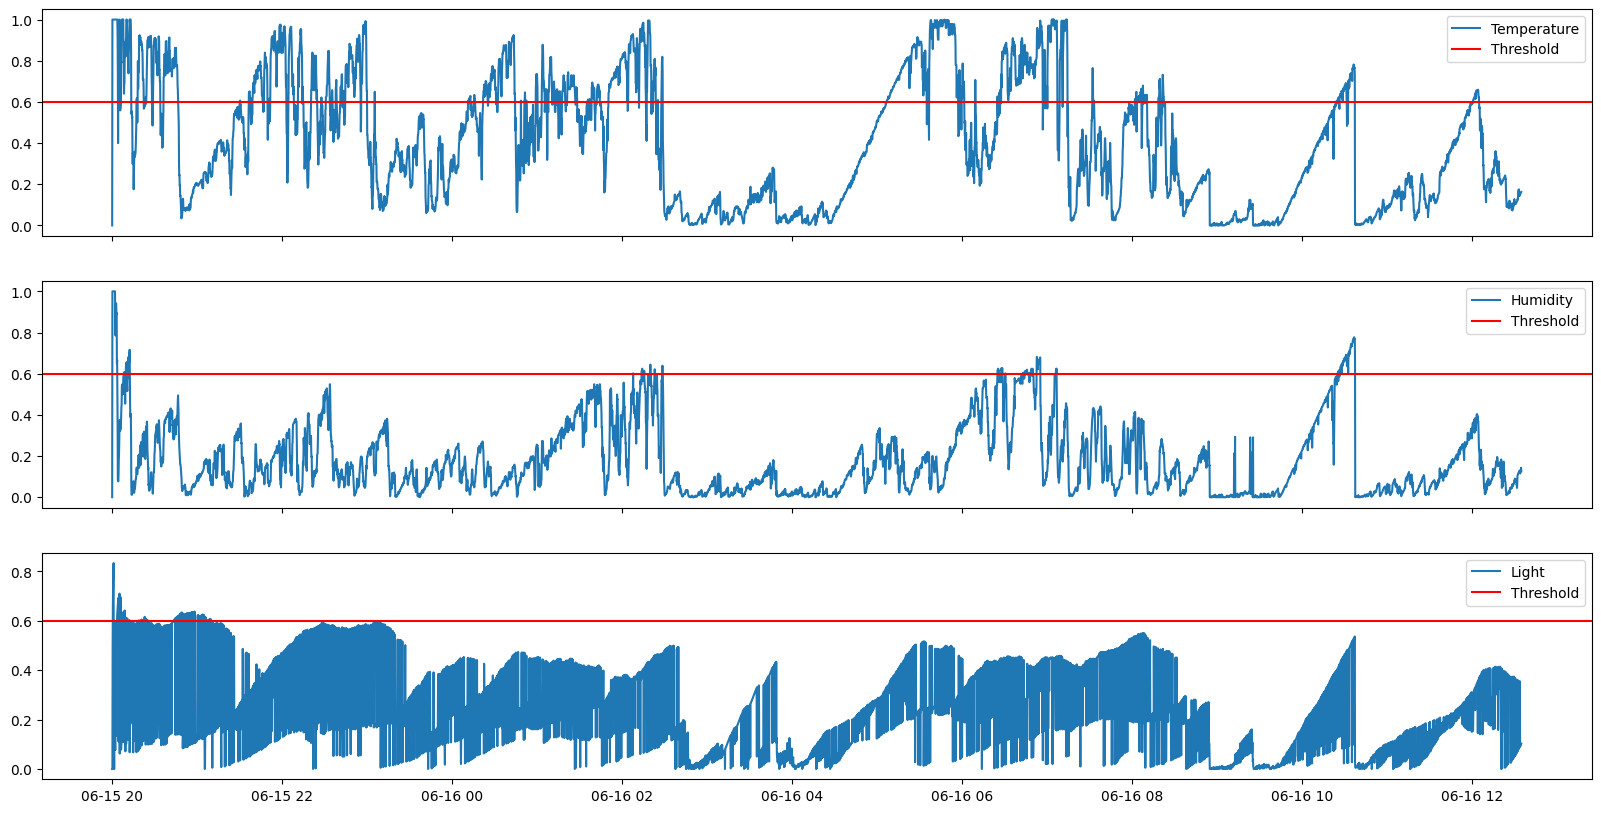

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    len(ts_column_to_be_used), 1, figsize=(20, 10), sharex=True, gridspec_kw={}
)
for idx, column in enumerate(ts_column_to_be_used):
    ax[idx].plot(timestamps, exact_storm_scores[column], label=column)
    ax[idx].axhline(y=UPPER_THRESHOLD, color="r", linestyle="-", label="Threshold")
    ax[idx].legend()

### Generate Chart for Comparing Ground Truth and Model Evaluation Result

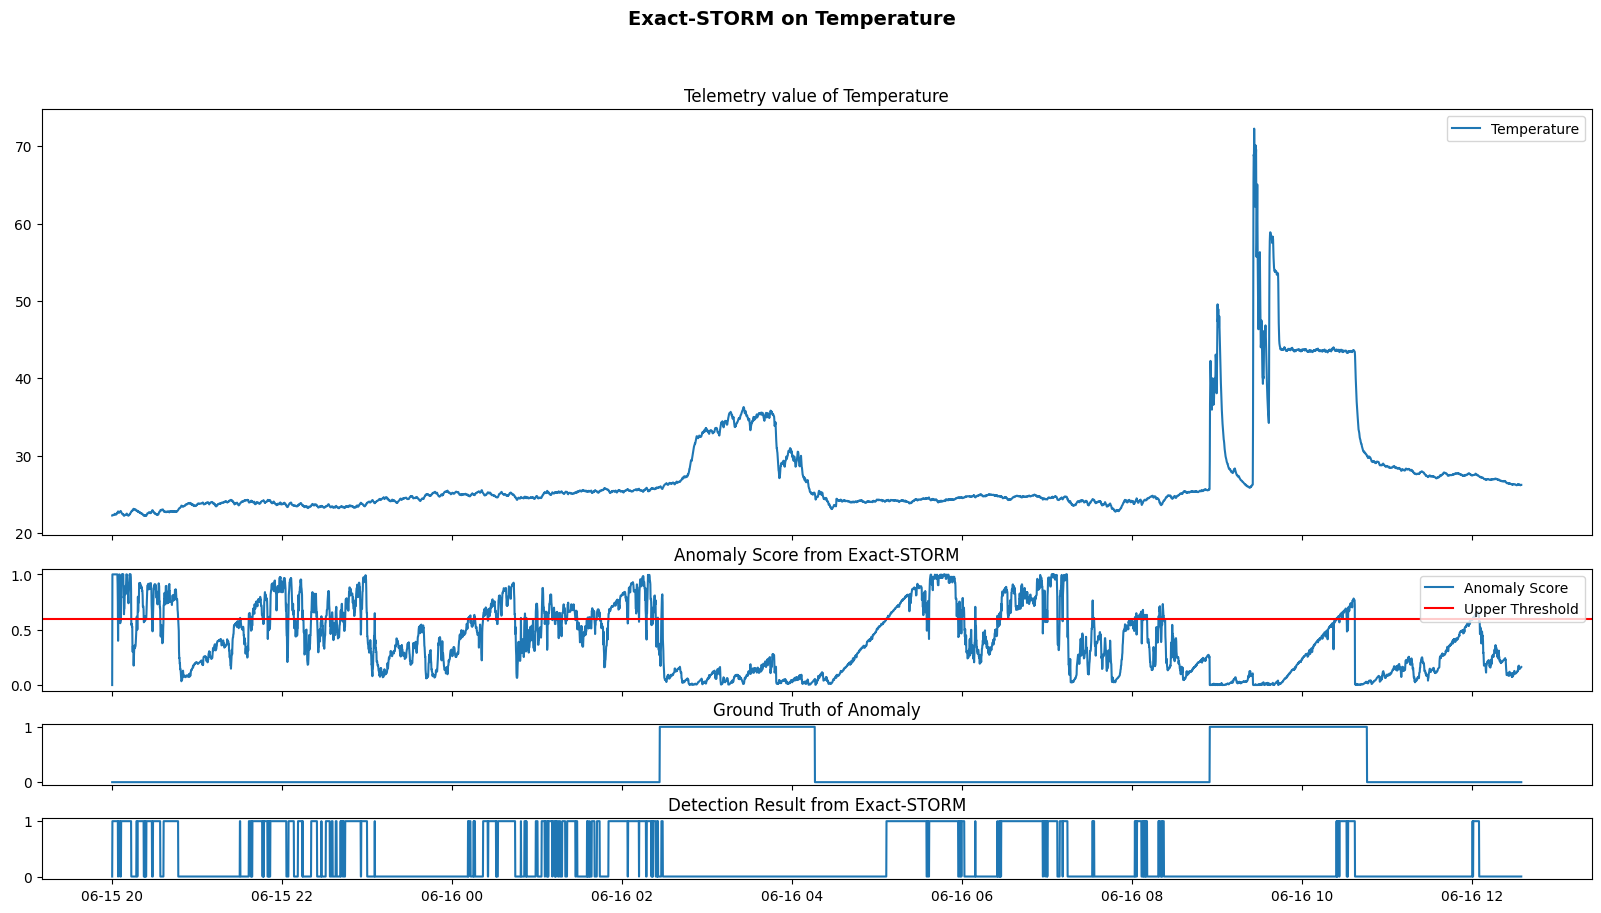

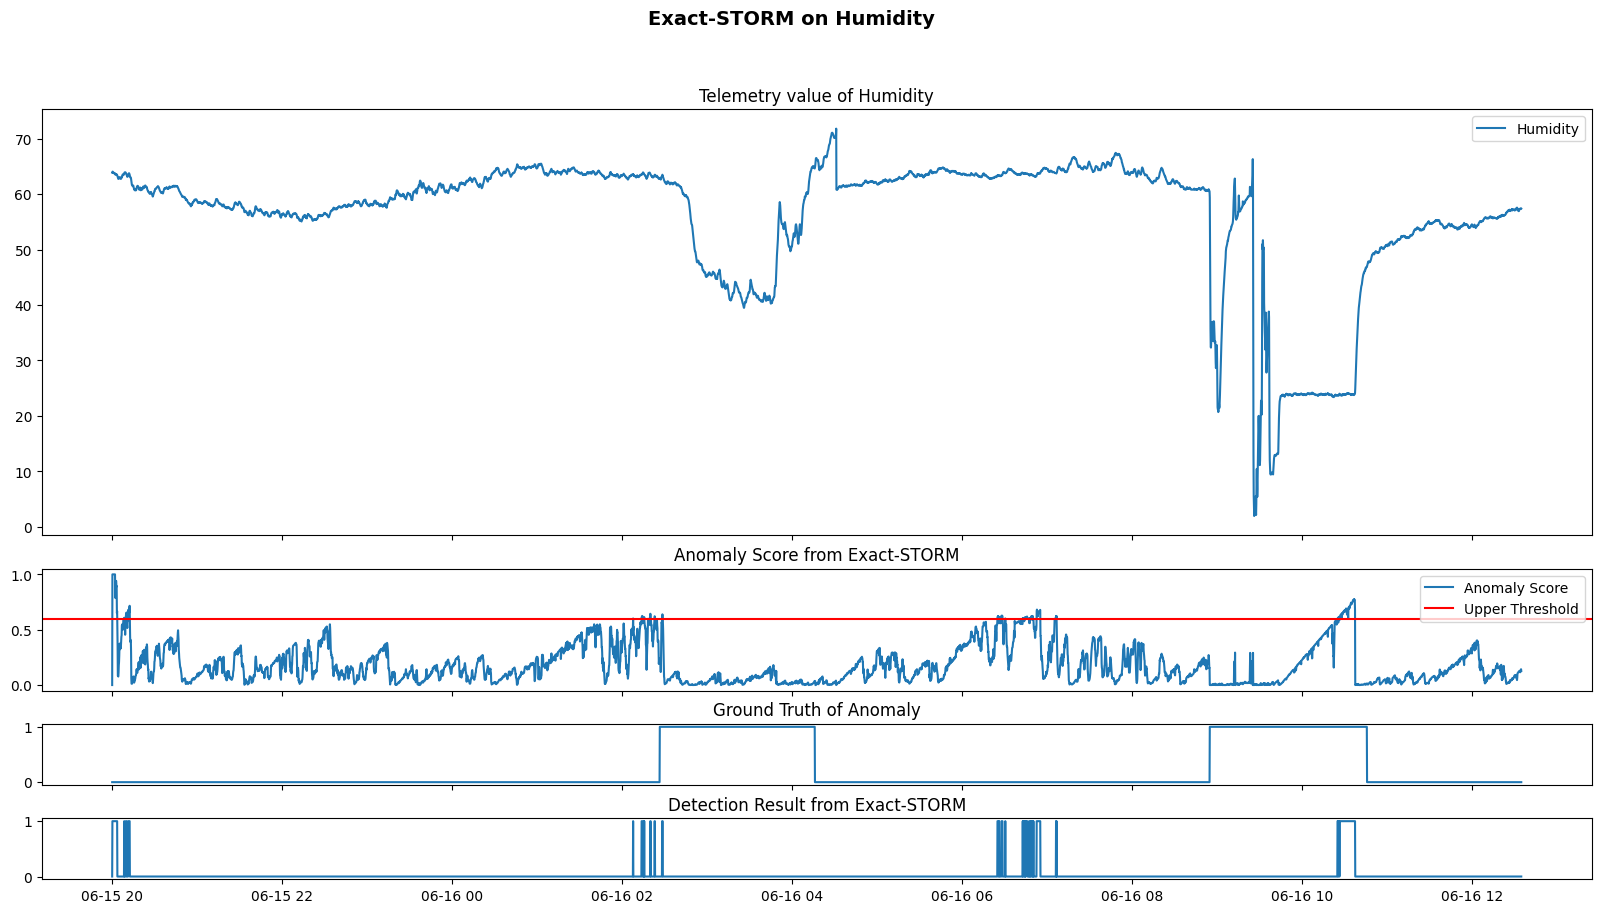

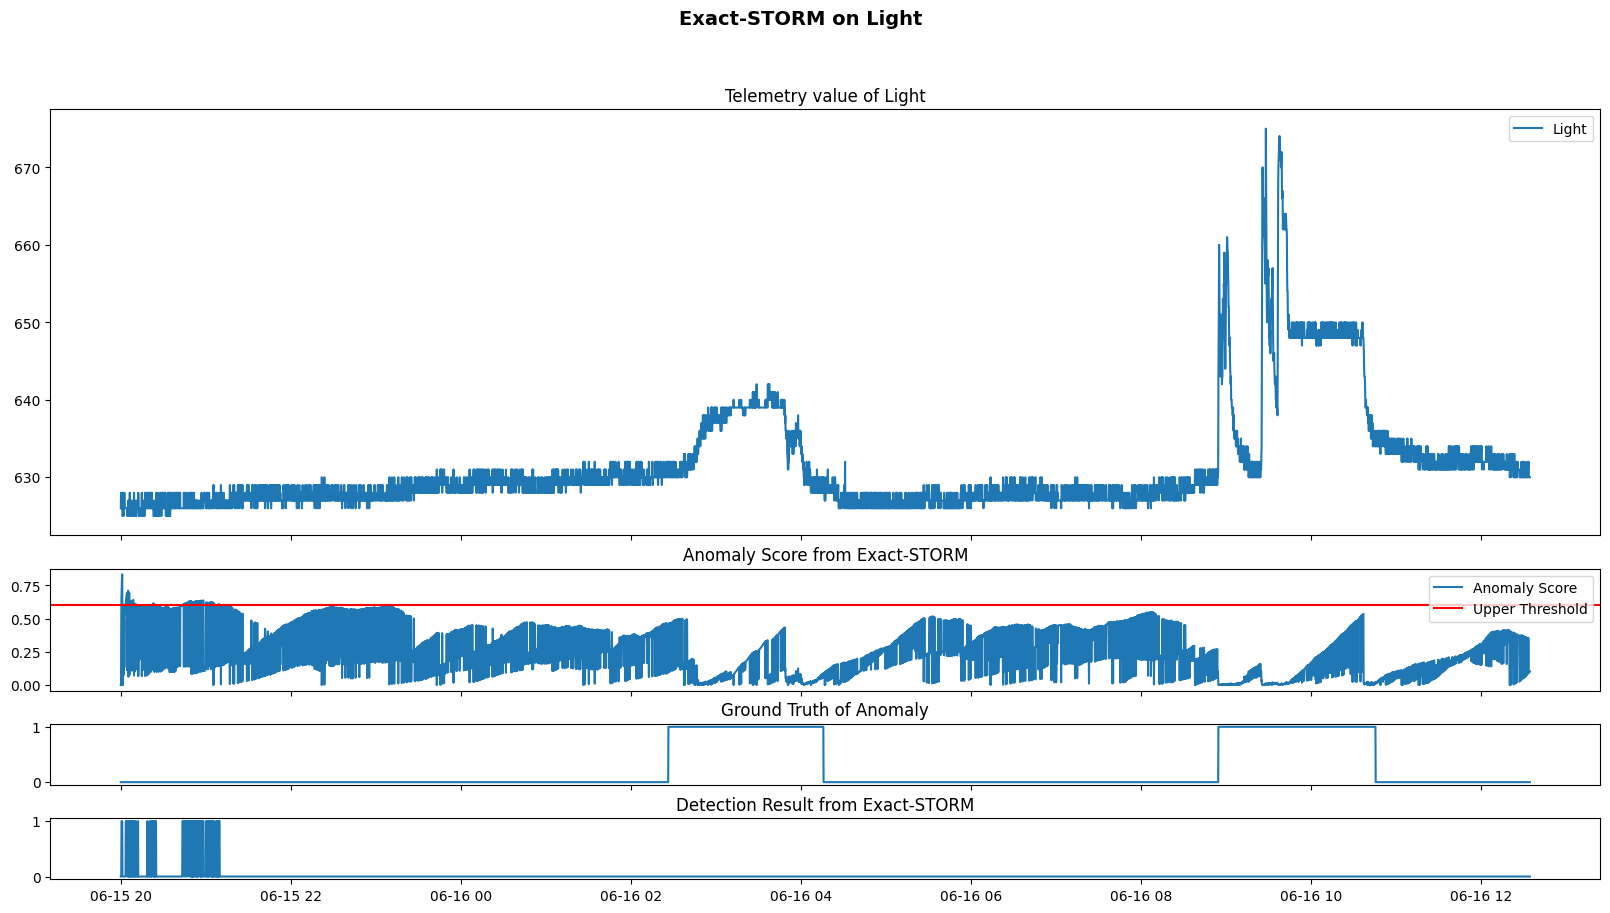

In [9]:
import matplotlib.pyplot as plt

model_name = "Exact-STORM"
for column in ts_column_to_be_used:
    fig, ax = plt.subplots(
        4,
        1,
        figsize=(20, 10),
        sharex=True,
        gridspec_kw={"height_ratios": [7, 2, 1, 1]},
    )
    ax[0].plot(timestamps, exact_storm_ts_values[column], label=column)
    ax[0].legend()
    ax[0].set_title(f"Telemetry value of {column}")
    ax[1].plot(timestamps, exact_storm_scores[column], label="Anomaly Score")
    ax[1].axhline(y=UPPER_THRESHOLD, color="r", linestyle="-", label="Upper Threshold")
    ax[1].legend()
    ax[1].set_title(f"Anomaly Score from {model_name}")
    ax[2].plot(timestamps, ground_truth, label="Ground Truth")
    ax[2].set_title("Ground Truth of Anomaly")
    ax[3].plot(timestamps, exact_storm_results[column], label="Detected Anomaly")
    ax[3].set_title(f"Detection Result from {model_name}")

    fig.suptitle(f"{model_name} on {column}", fontweight="bold", fontsize=14)
    fig.savefig(f"./results/{model_name}_{column}.png")

### Anomaly Detection Accuracy

In [10]:
from sklearn.metrics import accuracy_score

for column in ts_column_to_be_used:
    print(
        f"Accuracy of {model_name} on {column}: {accuracy_score(ground_truth, exact_storm_results[column])}"
    )

Accuracy of Exact-STORM on Temperature: 0.5020107238605898
Accuracy of Exact-STORM on Humidity: 0.7742962466487936
Accuracy of Exact-STORM on Light: 0.7548592493297587


## Isolation Forest Algorithm for Streaming Data using Sliding Window

`pysad.models.IForestASD`

### Model Training and Prediction

In [11]:
from collections import defaultdict

i_forest_ts_values = defaultdict(list)
i_forest_scores = defaultdict(list)
i_forest_results = defaultdict(list)

In [12]:
from collections import defaultdict
from pysad.models import IForestASD
import numpy as np
import multiprocessing
import time

HIGHER_THRESHOLD = 0.1

i_forest_model_map = defaultdict(lambda: IForestASD(window_size=2000))


def learning_and_detecting_anomaly(ts_column):
    values = []
    scores = []
    results = []

    start_time = time.time()

    for _, row in anoml_iot_dataset.iterrows():
        ts_value = row[ts_column]
        features = np.array([row[ts_column]])
        score = i_forest_model_map[ts_column].fit_score_partial(features)
        scores.append(score)  # Save the score
        result = get_decision_by_threshold(score, upper=HIGHER_THRESHOLD)
        values.append(ts_value)
        results.append(result)  # Save the evaluation result

    end_time = time.time()
    print(
        (
            f"[Performance of {ts_column}]\n"
            f"Time taken for all record (s): {{:.5f}}\n"
            f"Avg time taken for each (s)  : {{:.10f}}\n"
        ).format(end_time - start_time, (end_time - start_time) / record_count)
    )

    return values, scores, results


pool = multiprocessing.Pool(processes=3)
output = pool.map(learning_and_detecting_anomaly, ts_column_to_be_used)

for idx, column in enumerate(ts_column_to_be_used):
    i_forest_ts_values[column] = output[idx][0]
    i_forest_scores[column] = output[idx][1]
    i_forest_results[column] = output[idx][2]

[Performance of Light]
Time taken for all record (s): 121.94449
Avg time taken for each (s)  : 0.0204330576

[Performance of Temperature]
Time taken for all record (s): 135.30302
Avg time taken for each (s)  : 0.0226714178

[Performance of Humidity]
Time taken for all record (s): 136.65756
Avg time taken for each (s)  : 0.0228983851



### Anomaly Detection Scores

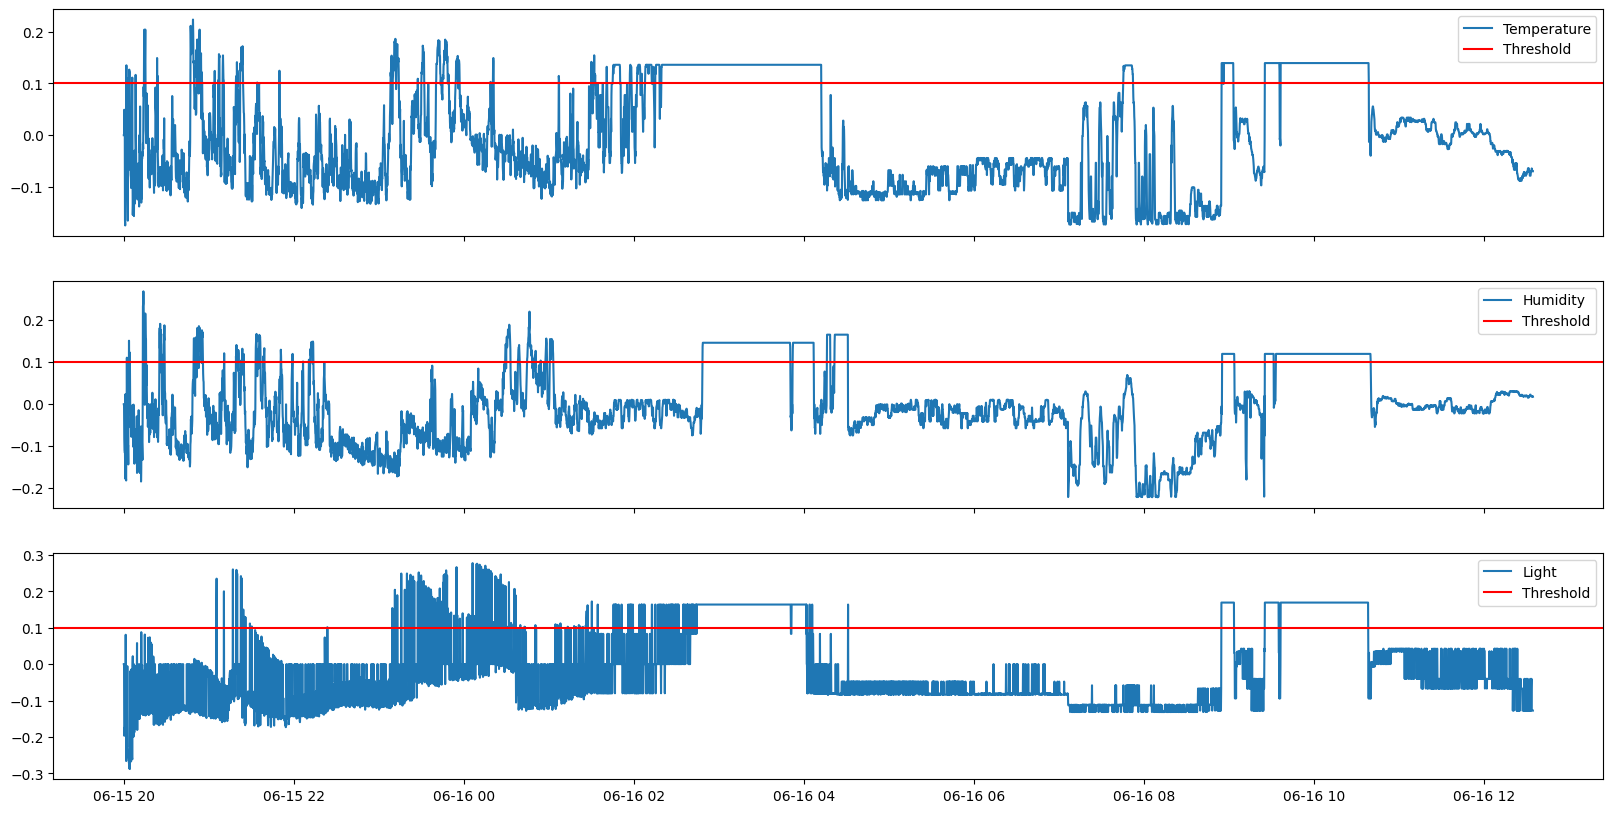

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    len(ts_column_to_be_used), 1, figsize=(20, 10), sharex=True, gridspec_kw={}
)

for idx, column in enumerate(ts_column_to_be_used):
    ax[idx].plot(timestamps, i_forest_scores[column], label=column)
    ax[idx].axhline(y=HIGHER_THRESHOLD, color="r", linestyle="-", label="Threshold")
    ax[idx].legend()

### Generate Chart for Comparing Ground Truth and Model Evaluation Result

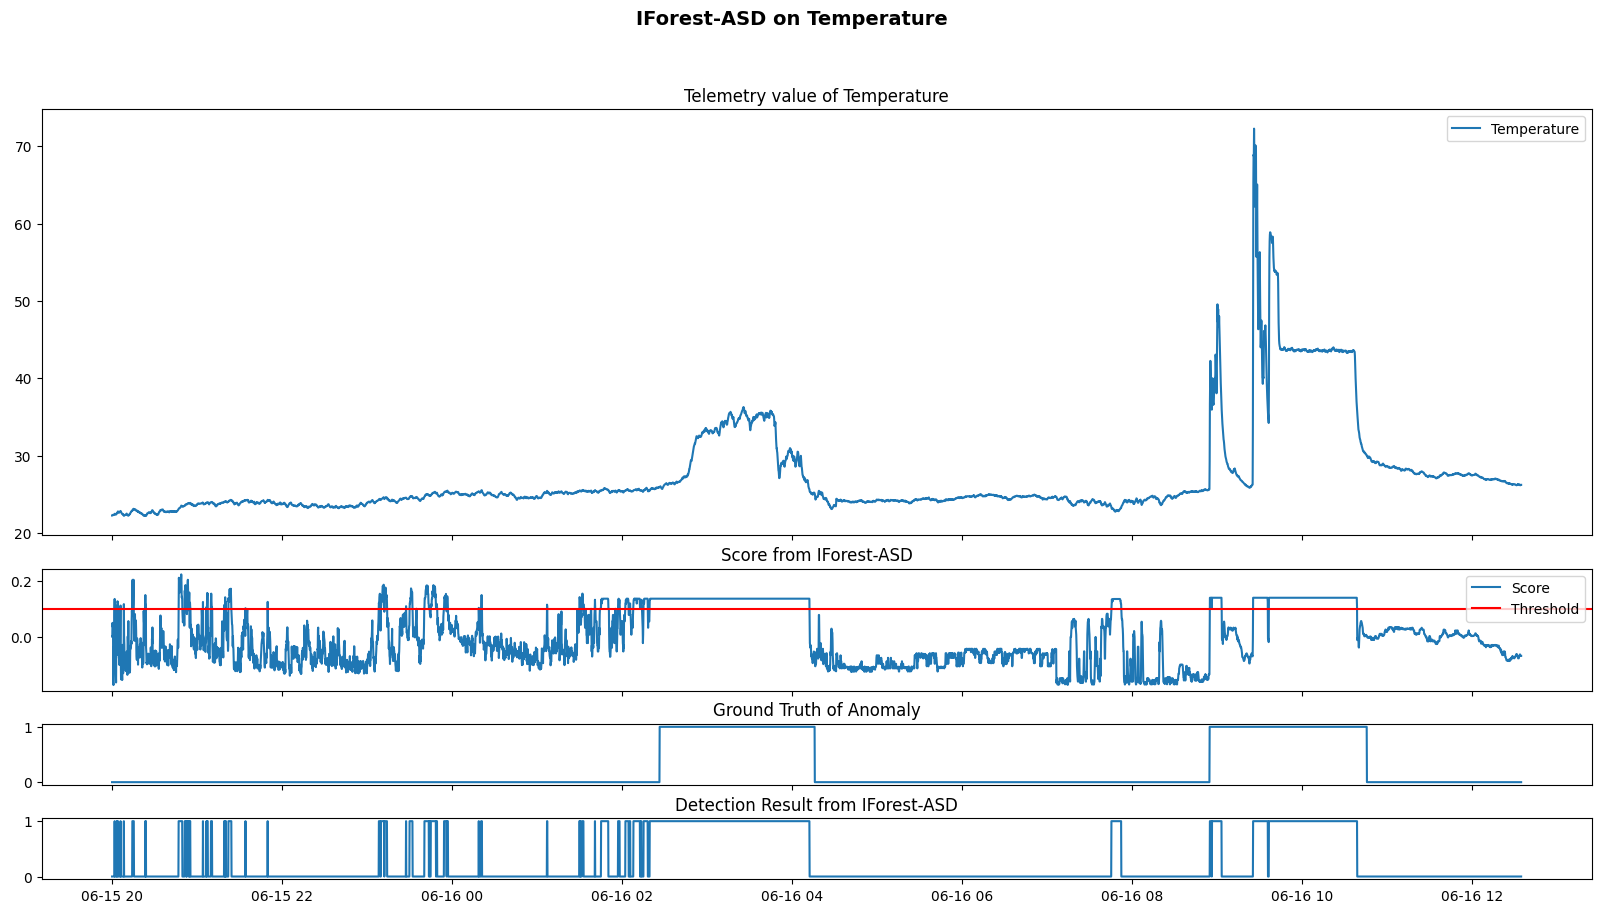

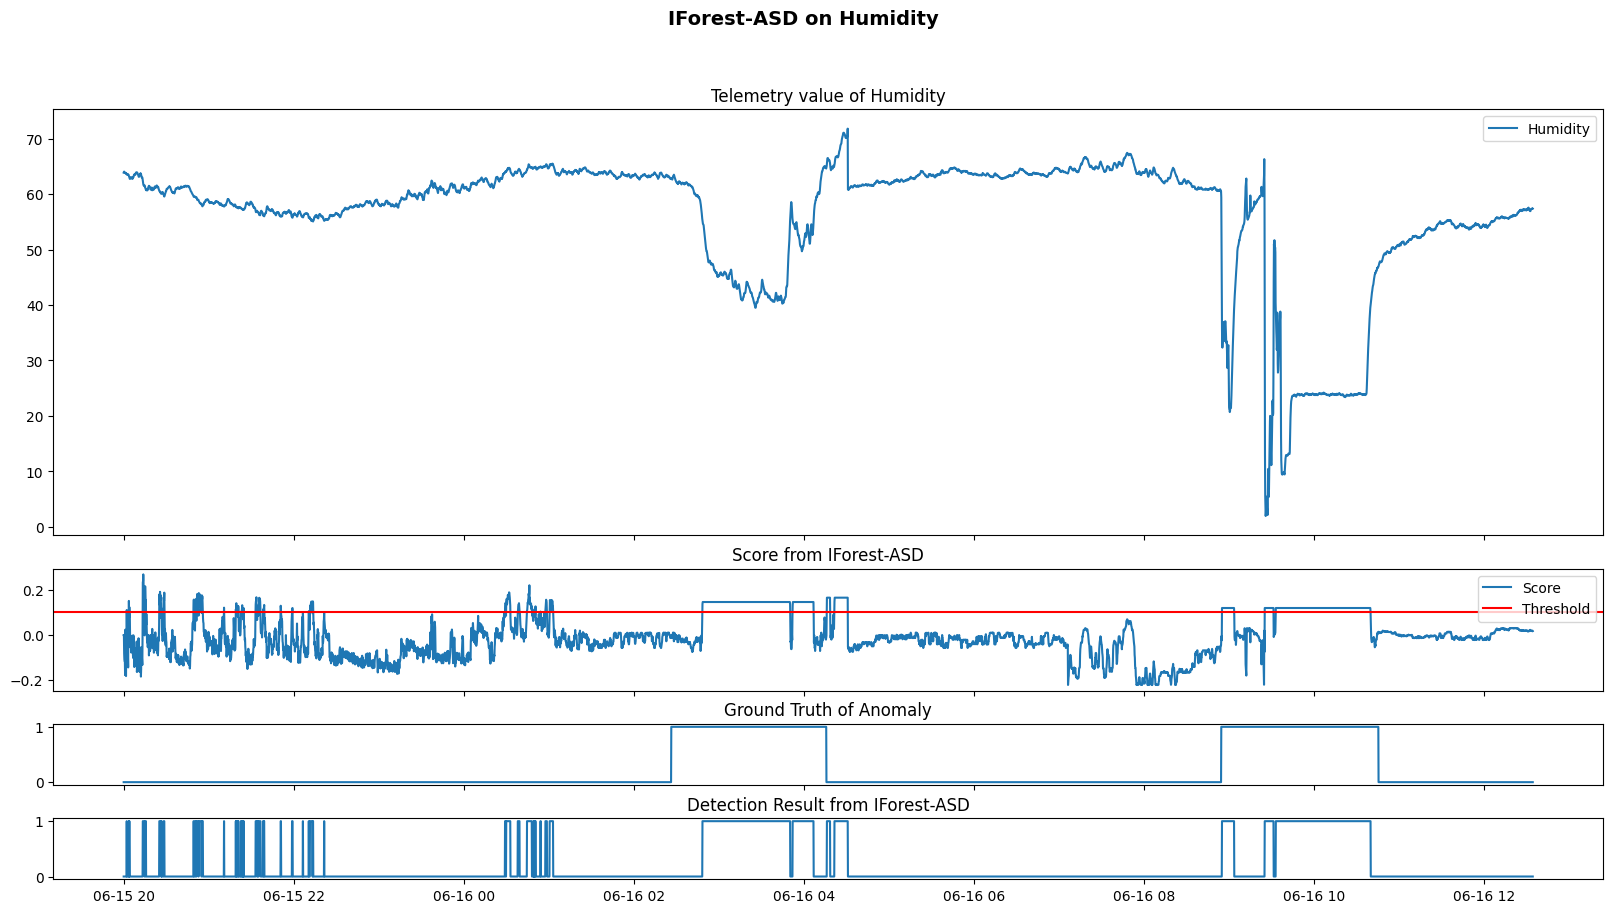

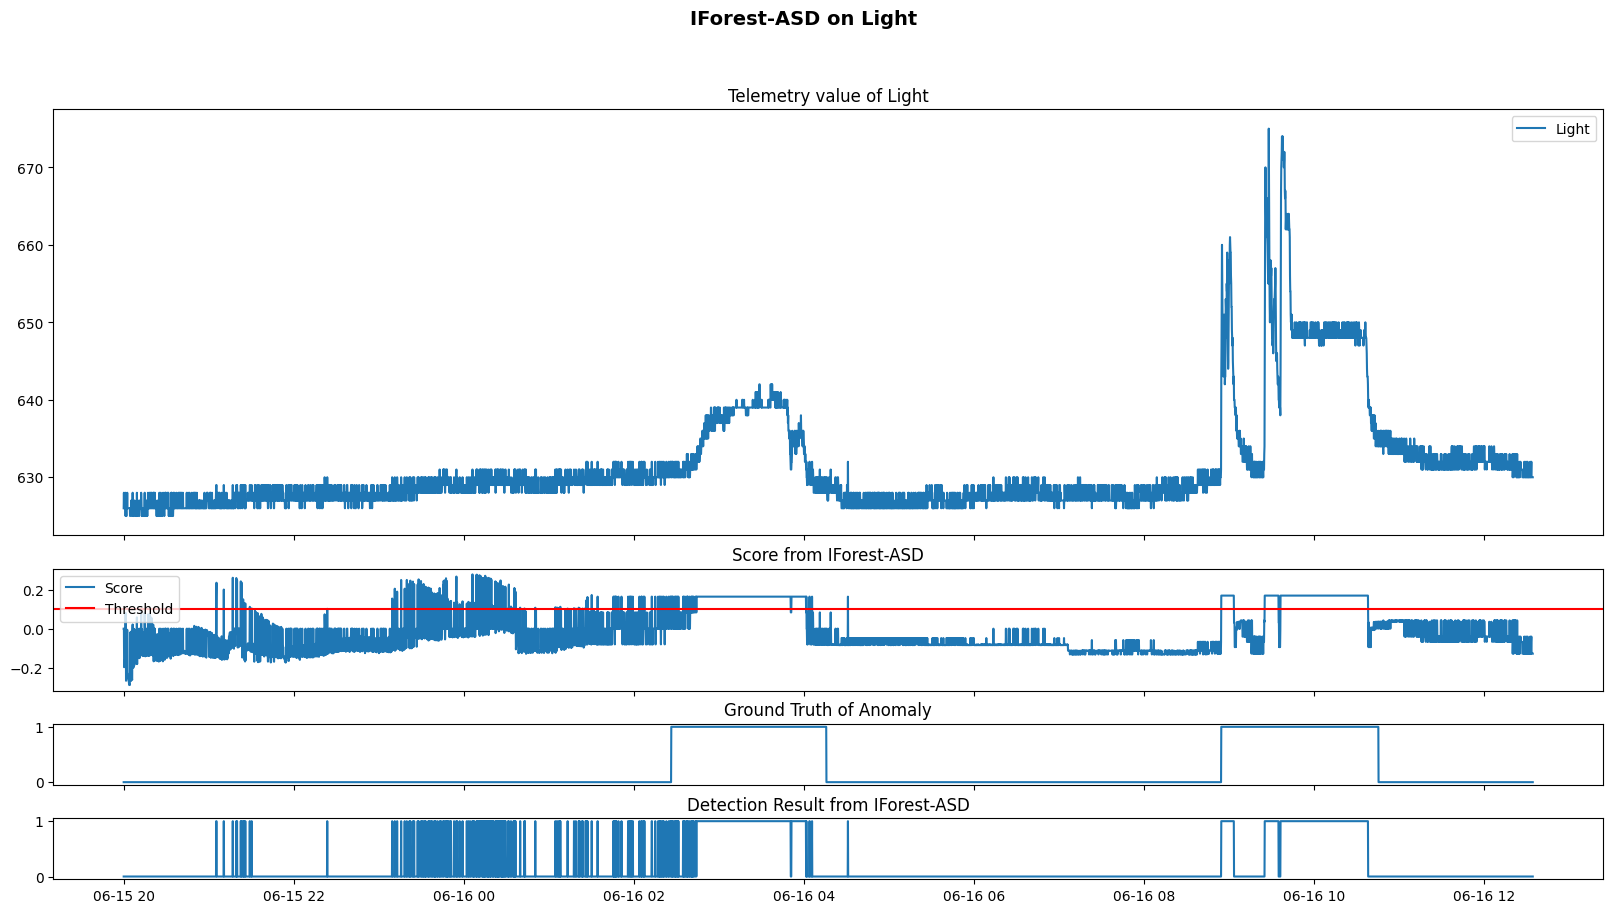

In [14]:
import matplotlib.pyplot as plt

model_name = "IForest-ASD"
for column in ts_column_to_be_used:
    fig, ax = plt.subplots(
        4,
        1,
        figsize=(20, 10),
        sharex=True,
        gridspec_kw={"height_ratios": [7, 2, 1, 1]},
    )
    ax[0].plot(timestamps, i_forest_ts_values[column], label=column)
    ax[0].legend()
    ax[0].set_title(f"Telemetry value of {column}")
    ax[1].plot(timestamps, i_forest_scores[column], label="Score")
    ax[1].axhline(y=HIGHER_THRESHOLD, color="r", linestyle="-", label="Threshold")
    ax[1].legend()
    ax[1].set_title(f"Score from {model_name}")
    ax[2].plot(timestamps, ground_truth, label="Ground Truth")
    ax[2].set_title("Ground Truth of Anomaly")
    ax[3].plot(timestamps, i_forest_results[column], label="Detected Anomaly")
    ax[3].set_title(f"Detection Result from {model_name}")

    fig.suptitle(f"{model_name} on {column}", fontweight="bold", fontsize=14)
    fig.savefig(f"./results/{model_name}_{column}.png")

### Anomaly Detection Accuracy

In [15]:
from sklearn.metrics import accuracy_score

for column in ts_column_to_be_used:
    print(
        f"Accuracy on {column}: {accuracy_score(ground_truth, i_forest_results[column])}"
    )

Accuracy on Temperature: 0.899798927613941
Accuracy on Humidity: 0.8927613941018767
Accuracy on Light: 0.9091823056300268


## KNNCAD

`pysad.models.KNNCAD`

### Model Training and Prediction

In [16]:
from collections import defaultdict

knncad_ts_values = defaultdict(list)
knncad_scores = defaultdict(list)
knncad_results = defaultdict(list)

In [17]:
from collections import defaultdict
from pysad.models import KNNCAD
import numpy as np
import multiprocessing
import time

UPPER_THRESHOLD = 0.7

knncad_model_map = defaultdict(lambda: KNNCAD(probationary_period=1200))


def learning_and_detecting_anomaly(ts_column):
    values = []
    scores = []
    results = []

    start_time = time.time()

    for _, row in anoml_iot_dataset.iterrows():
        ts_value = row[ts_column]
        features = np.array([row[ts_column]])
        score = knncad_model_map[ts_column].fit_score_partial(features)
        scores.append(score)  # Save the score
        result = get_decision_by_threshold(score, upper=UPPER_THRESHOLD)
        values.append(ts_value)
        results.append(result)  # Save the evaluation result

    end_time = time.time()
    print(
        (
            f"[Performance of {ts_column}]\n"
            f"Time taken for all record (s): {{:.5f}}\n"
            f"Avg time taken for each (s)  : {{:.10f}}\n"
        ).format(end_time - start_time, (end_time - start_time) / record_count)
    )

    return values, scores, results


pool = multiprocessing.Pool(processes=3)
output = pool.map(learning_and_detecting_anomaly, ts_column_to_be_used)

for idx, column in enumerate(ts_column_to_be_used):
    knncad_ts_values[column] = output[idx][0]
    knncad_scores[column] = output[idx][1]
    knncad_results[column] = output[idx][2]

[Performance of Temperature]
Time taken for all record (s): 46.95448
Avg time taken for each (s)  : 0.0078677079

[Performance of Humidity]
Time taken for all record (s): 47.00337
Avg time taken for each (s)  : 0.0078759003

[Performance of Light]
Time taken for all record (s): 47.32689
Avg time taken for each (s)  : 0.0079301090



### Anomaly Detection Scores

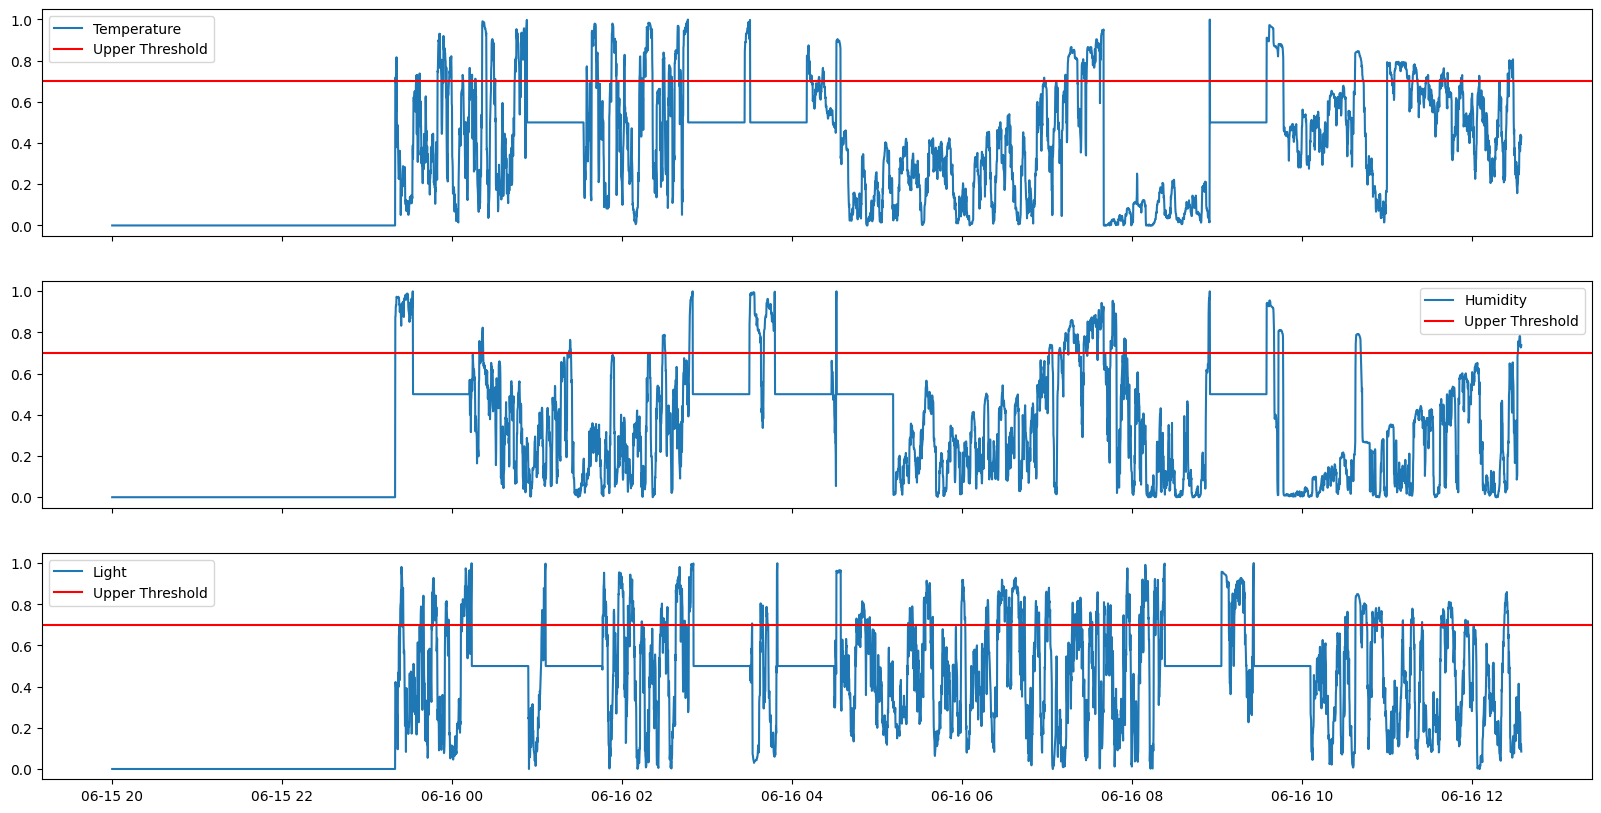

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    len(ts_column_to_be_used), 1, figsize=(20, 10), sharex=True, gridspec_kw={}
)

for idx, column in enumerate(ts_column_to_be_used):
    ax[idx].plot(timestamps, knncad_scores[column], label=column)
    ax[idx].axhline(
        y=UPPER_THRESHOLD, color="r", linestyle="-", label="Upper Threshold"
    )
    ax[idx].legend()

### Generate Chart for Comparing Ground Truth and Model Evaluation Result

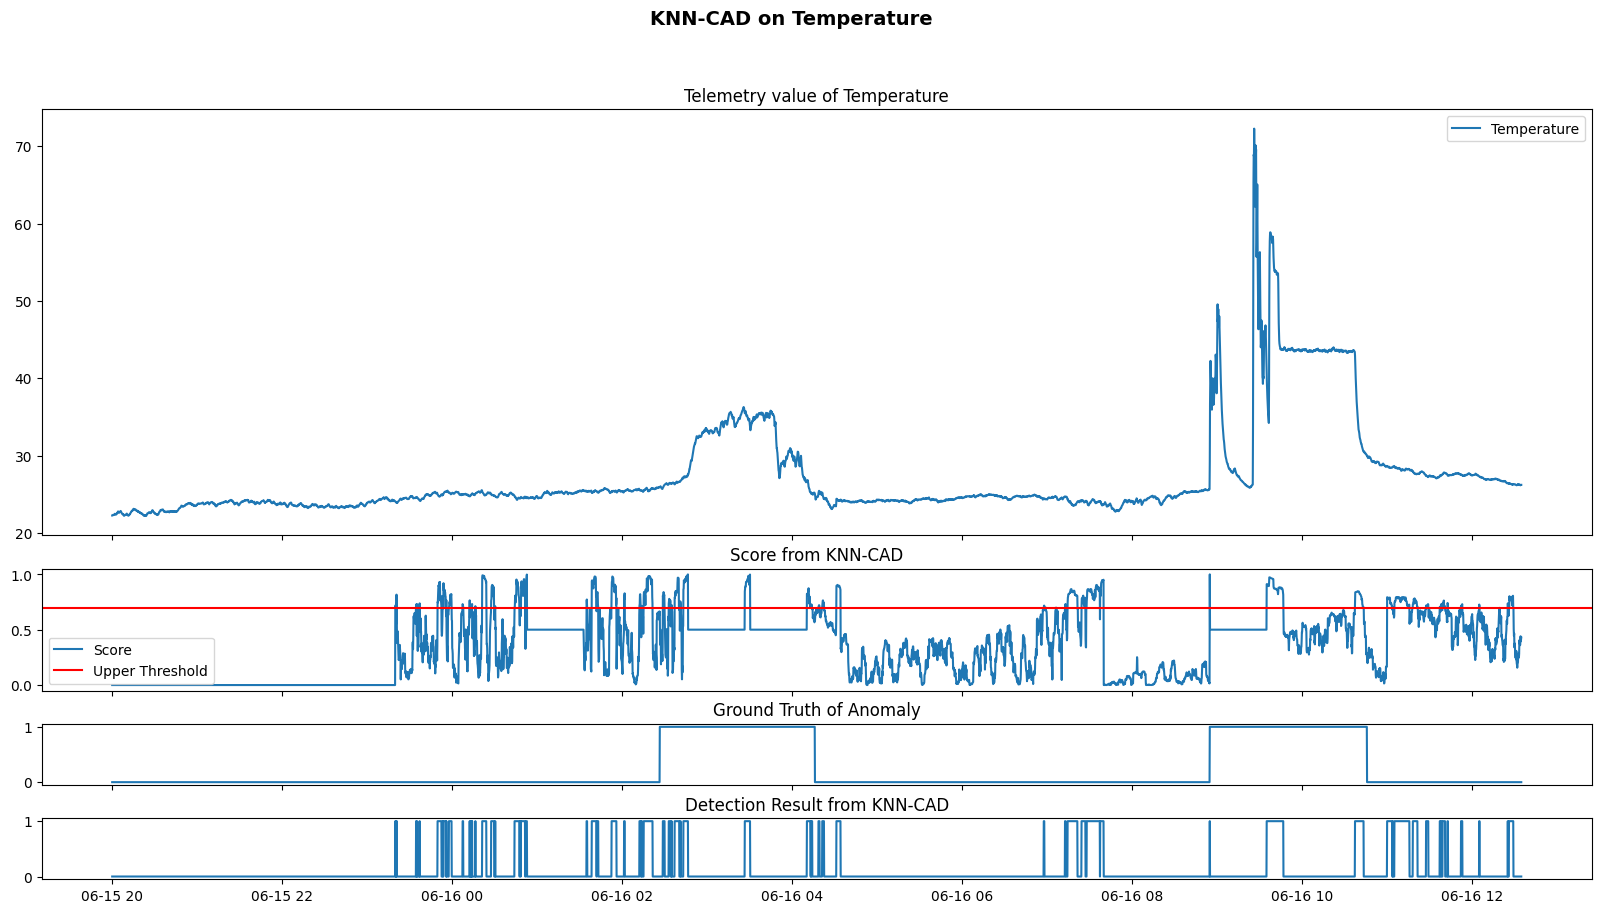

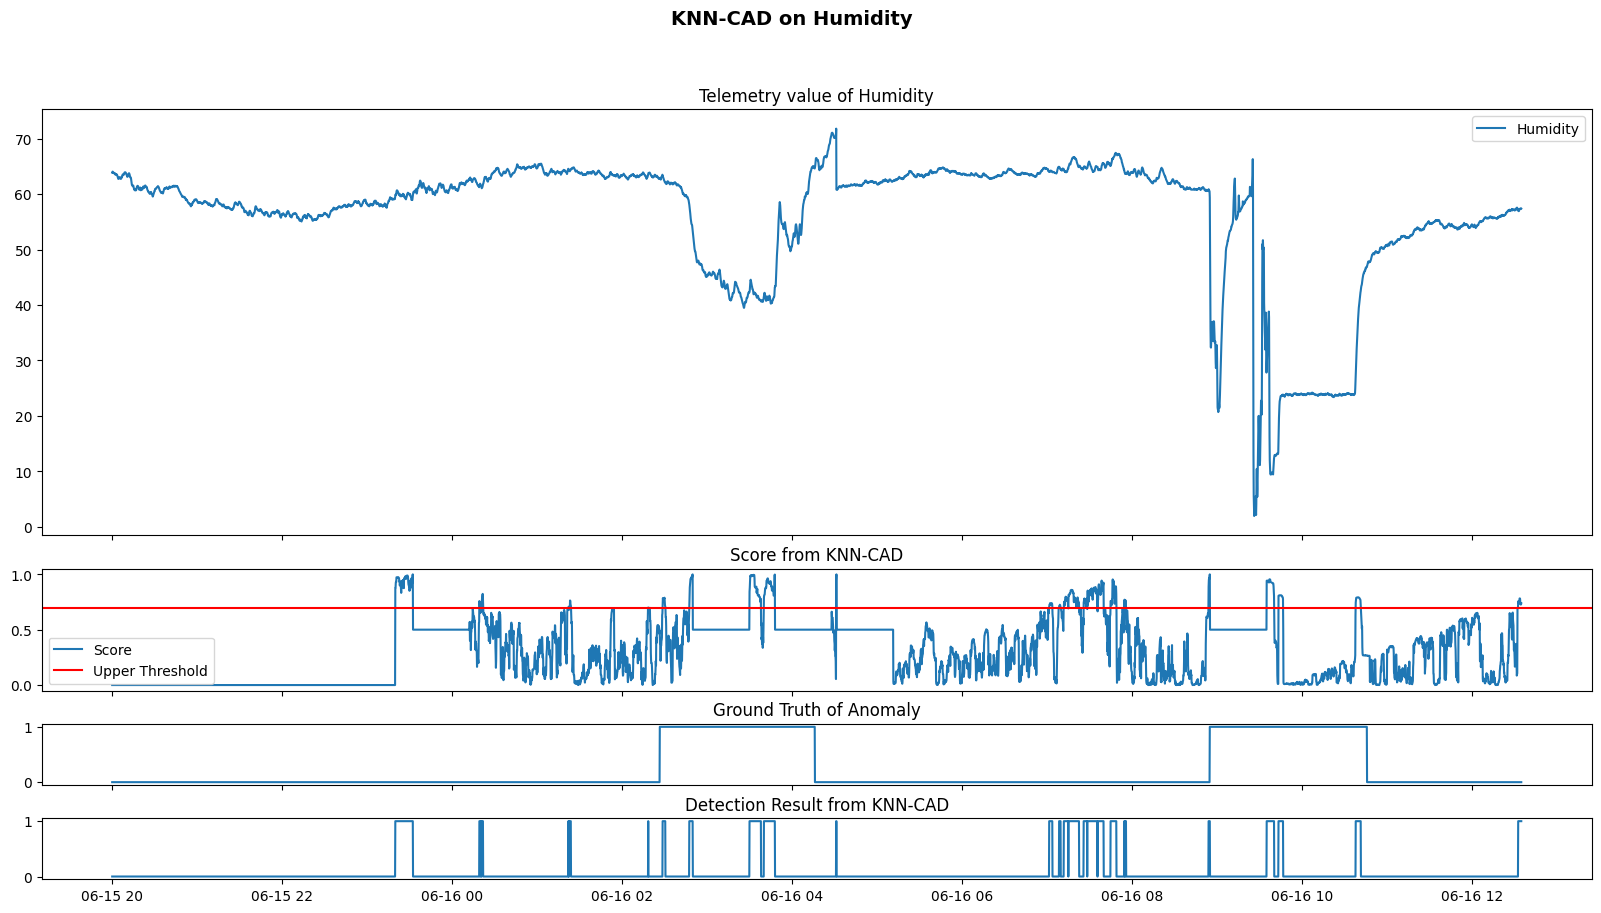

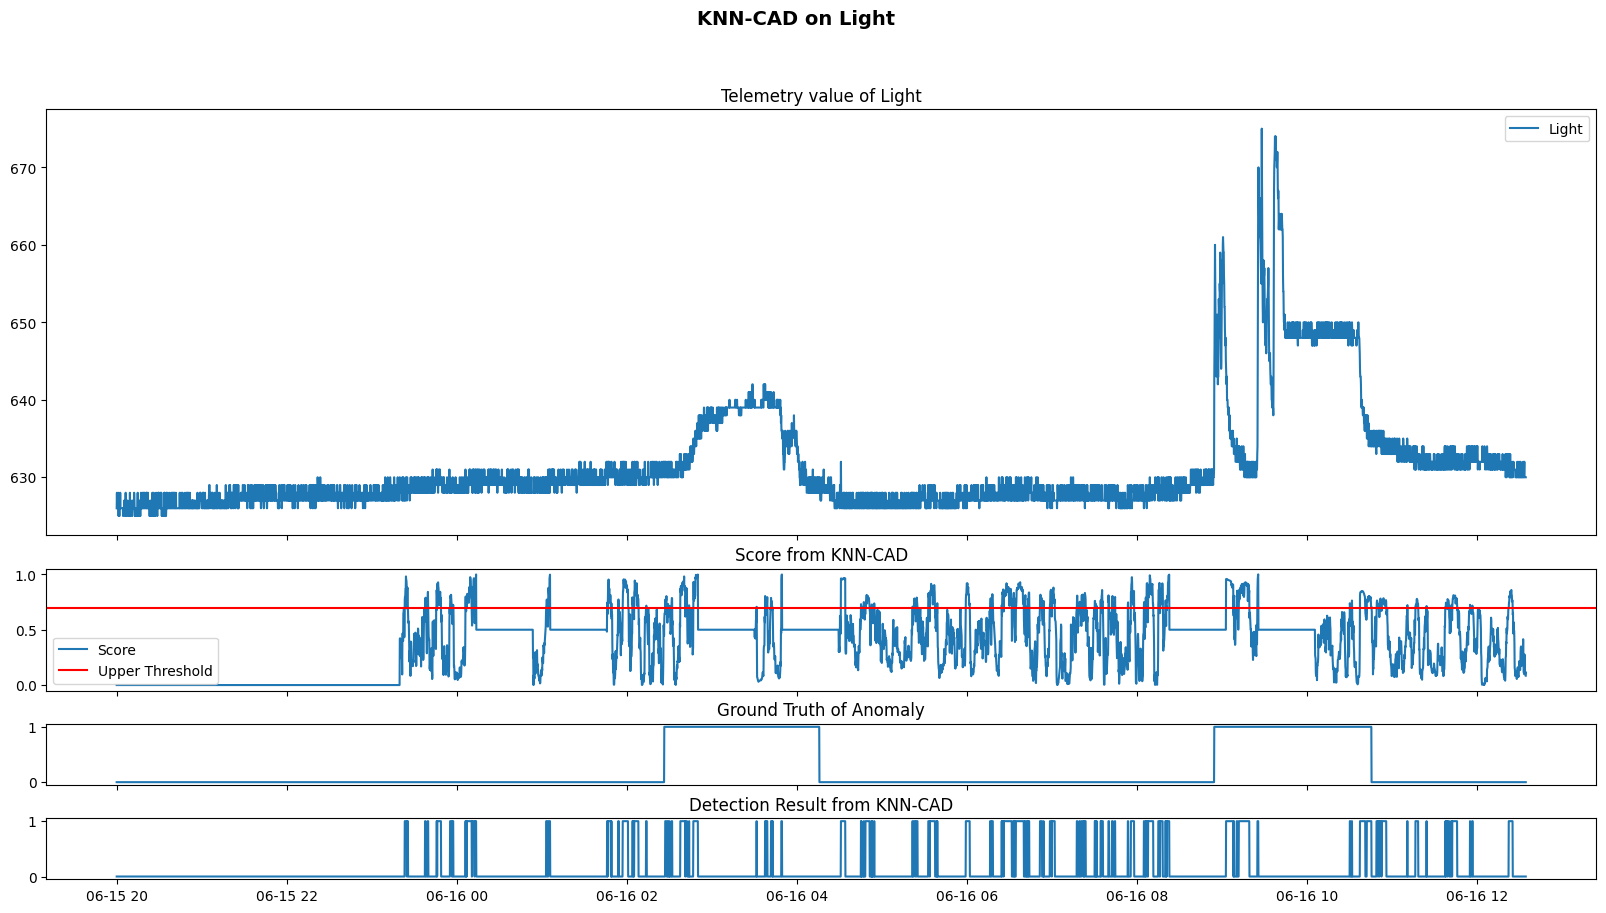

In [19]:
import matplotlib.pyplot as plt

model_name = "KNN-CAD"
for column in ts_column_to_be_used:
    fig, ax = plt.subplots(
        4,
        1,
        figsize=(20, 10),
        sharex=True,
        gridspec_kw={"height_ratios": [7, 2, 1, 1]},
    )
    ax[0].plot(timestamps, knncad_ts_values[column], label=column)
    ax[0].legend()
    ax[0].set_title(f"Telemetry value of {column}")
    ax[1].plot(timestamps, knncad_scores[column], label="Score")
    ax[1].axhline(y=UPPER_THRESHOLD, color="r", linestyle="-", label="Upper Threshold")
    ax[1].legend()
    ax[1].set_title(f"Score from {model_name}")
    ax[2].plot(timestamps, ground_truth, label="Ground Truth")
    ax[2].set_title("Ground Truth of Anomaly")
    ax[3].plot(timestamps, knncad_results[column], label="Detected Anomaly")
    ax[3].set_title(f"Detection Result from {model_name}")

    fig.suptitle(f"{model_name} on {column}", fontweight="bold", fontsize=14)
    fig.savefig(f"./results/{model_name}_{column}.png")

### Anomaly Detection Accuracy

In [20]:
from sklearn.metrics import accuracy_score

for column in ts_column_to_be_used:
    print(
        f"Accuracy of {model_name} on {column}: {accuracy_score(ground_truth, knncad_results[column])}"
    )

Accuracy of KNN-CAD on Temperature: 0.7186662198391421
Accuracy of KNN-CAD on Humidity: 0.7588806970509383
Accuracy of KNN-CAD on Light: 0.7074396782841823


## Standard Absolute Deviation

`pysad.models.StandardAbsoluteDeviation`

### Model Training and Prediction

In [21]:
from collections import defaultdict

sad_ts_values = defaultdict(list)
sad_scores = defaultdict(list)
sad_results = defaultdict(list)

In [22]:
from collections import defaultdict
from pysad.models import StandardAbsoluteDeviation
import numpy as np
import multiprocessing
import time

UPPER_THRESHOLD = 1.6

sad_model_map = defaultdict(lambda: StandardAbsoluteDeviation())


def learning_and_detecting_anomaly(ts_column):
    values = []
    scores = []
    results = []

    start_time = time.time()

    for _, row in anoml_iot_dataset.iterrows():
        ts_value = row[ts_column]
        features = np.array([row[ts_column]])
        score = sad_model_map[ts_column].fit_score_partial(features)
        scores.append(score)  # Save the score
        result = get_decision_by_threshold(score, upper=UPPER_THRESHOLD)
        values.append(ts_value)
        results.append(result)  # Save the evaluation result

    end_time = time.time()
    print(
        f"""[Performance of {ts_column}]
Time taken for all record (s): {{:.5f}}
Avg time taken for each (s)  : {{:.10f}}
""".format(
            end_time - start_time, (end_time - start_time) / record_count
        )
    )

    return values, scores, results


pool = multiprocessing.Pool(processes=3)
output = pool.map(learning_and_detecting_anomaly, ts_column_to_be_used)

for idx, column in enumerate(ts_column_to_be_used):
    sad_ts_values[column] = output[idx][0]
    sad_scores[column] = output[idx][1]
    sad_results[column] = output[idx][2]

[Performance of Temperature]
Time taken for all record (s): 0.20306
Avg time taken for each (s)  : 0.0000340252
[Performance of Light]
Time taken for all record (s): 0.20354
Avg time taken for each (s)  : 0.0000341050


[Performance of Humidity]
Time taken for all record (s): 0.20692
Avg time taken for each (s)  : 0.0000346709



### Anomaly Detection Scores

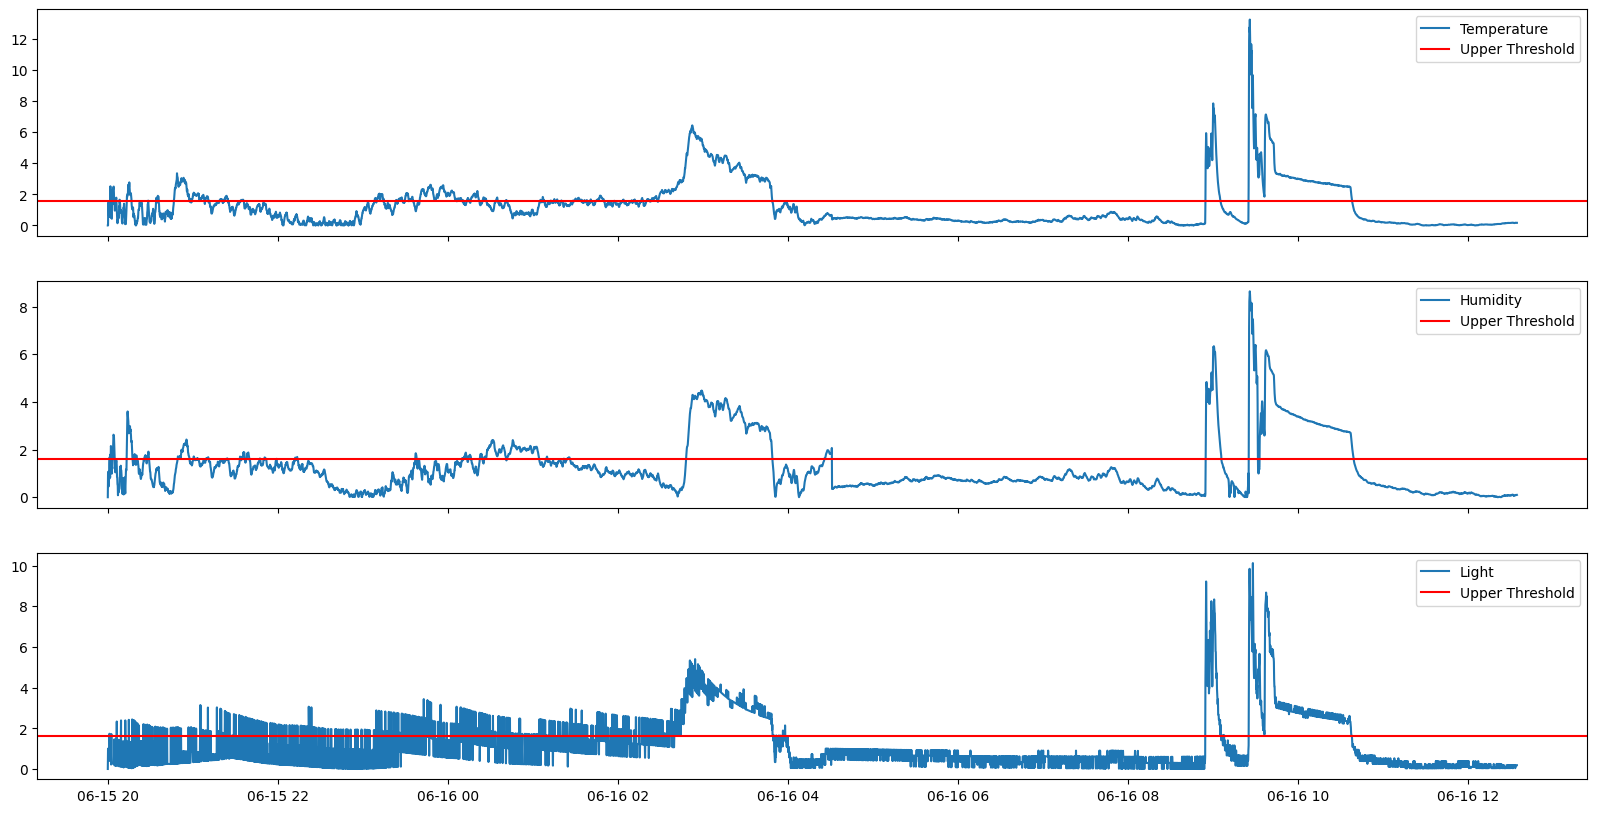

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    len(ts_column_to_be_used), 1, figsize=(20, 10), sharex=True, gridspec_kw={}
)

for idx, column in enumerate(ts_column_to_be_used):
    ax[idx].plot(timestamps, sad_scores[column], label=column)
    ax[idx].axhline(
        y=UPPER_THRESHOLD, color="r", linestyle="-", label="Upper Threshold"
    )
    ax[idx].legend()

### Generate Chart for Comparing Ground Truth and Model Evaluation Result

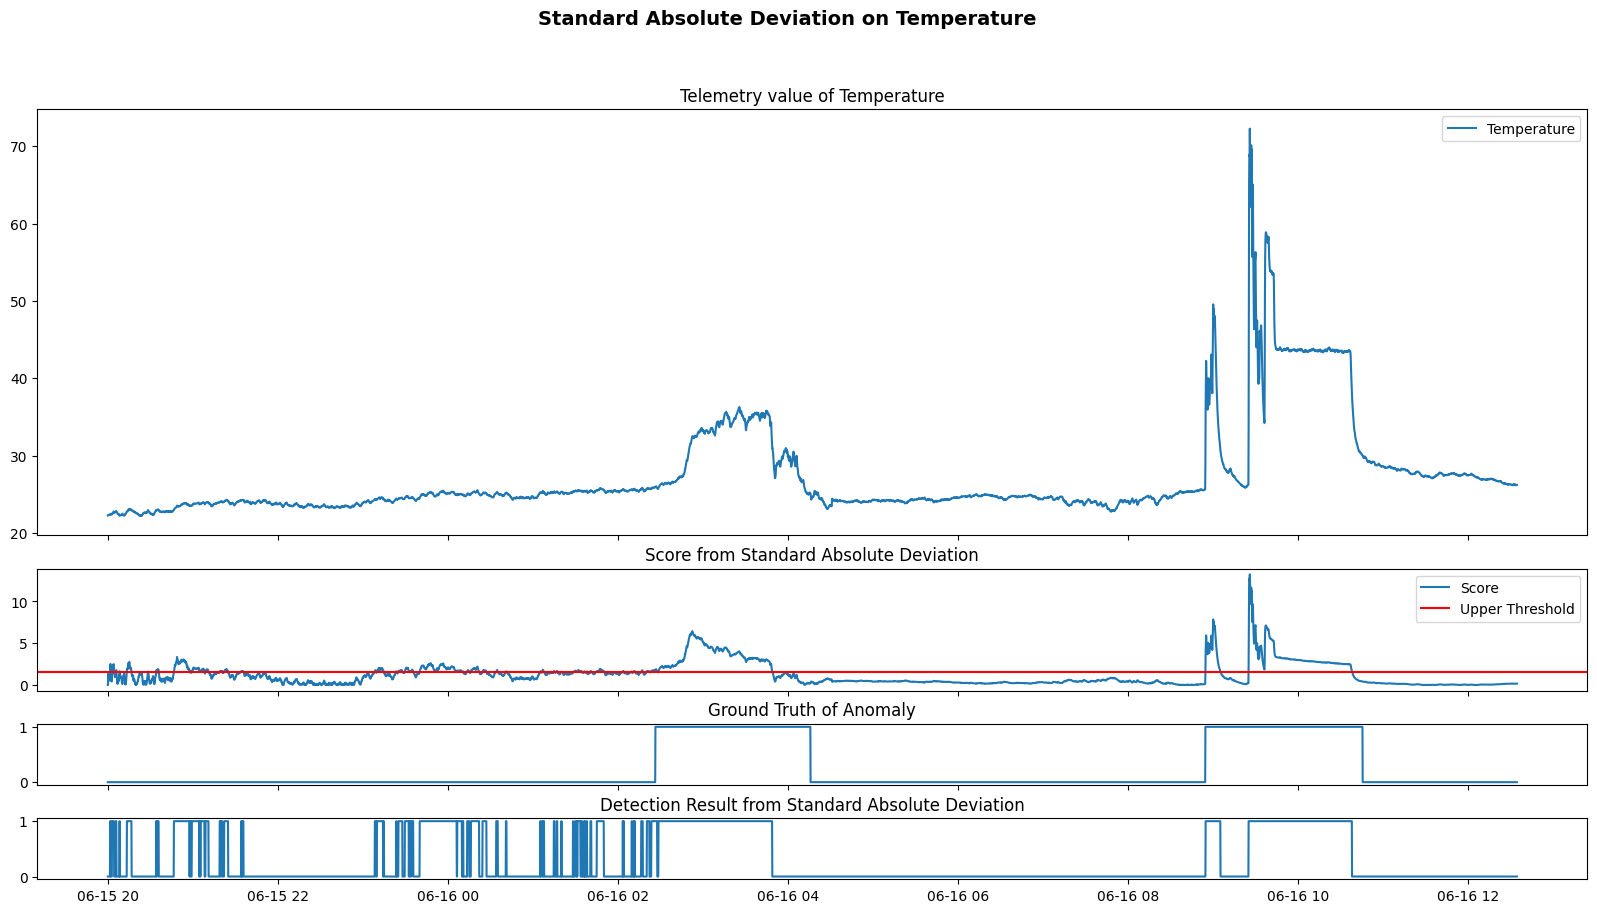

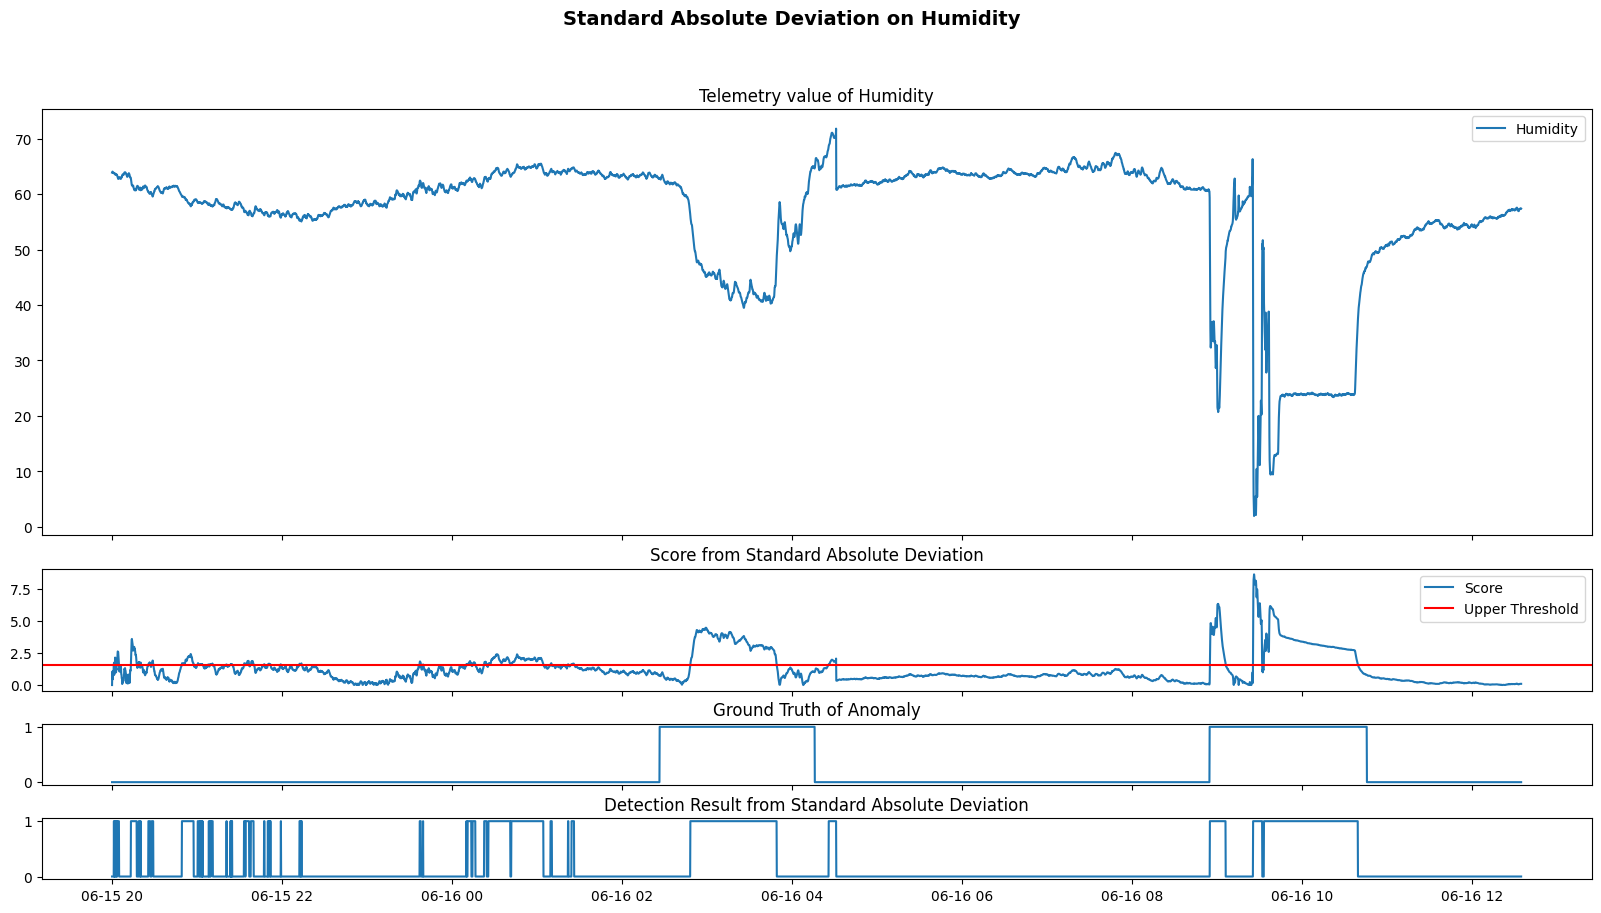

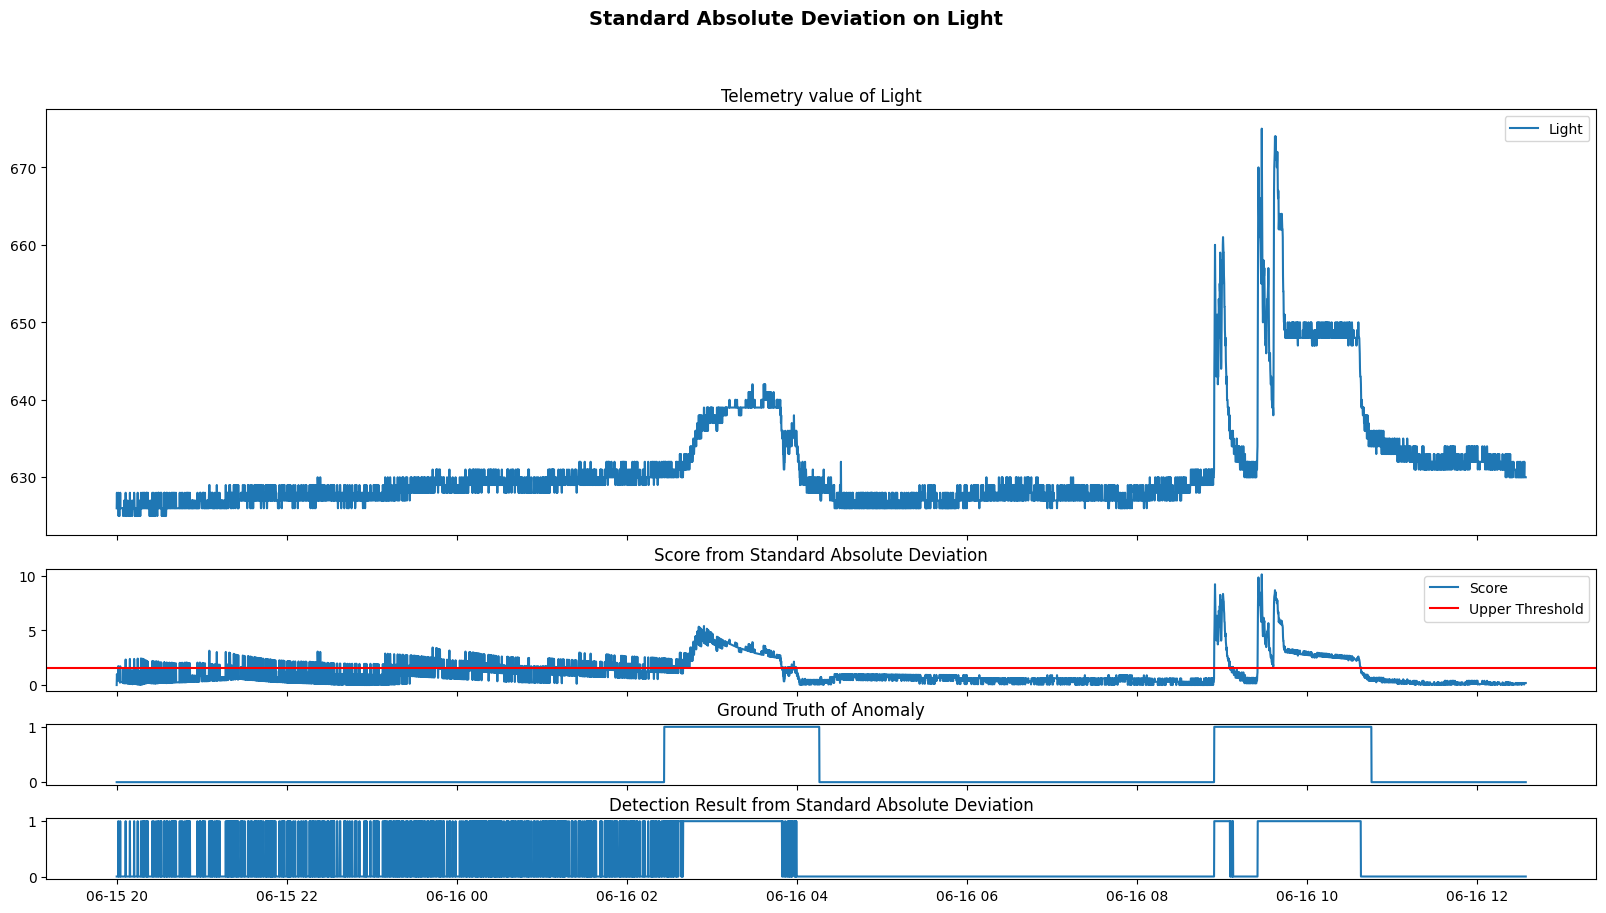

In [24]:
import matplotlib.pyplot as plt

model_name = "Standard Absolute Deviation"
for column in ts_column_to_be_used:
    fig, ax = plt.subplots(
        4,
        1,
        figsize=(20, 10),
        sharex=True,
        gridspec_kw={"height_ratios": [7, 2, 1, 1]},
    )
    ax[0].plot(timestamps, sad_ts_values[column], label=column)
    ax[0].legend()
    ax[0].set_title(f"Telemetry value of {column}")
    ax[1].plot(timestamps, sad_scores[column], label="Score")
    ax[1].axhline(y=UPPER_THRESHOLD, color="r", linestyle="-", label="Upper Threshold")
    ax[1].legend()
    ax[1].set_title(f"Score from {model_name}")
    ax[2].plot(timestamps, ground_truth, label="Ground Truth")
    ax[2].set_title("Ground Truth of Anomaly")
    ax[3].plot(timestamps, sad_results[column], label="Detected Anomaly")
    ax[3].set_title(f"Detection Result from {model_name}")

    fig.suptitle(f"{model_name} on {column}", fontweight="bold", fontsize=14)
    fig.savefig(f"./results/{model_name}_{column}.png")

### Anomaly Detection Accuracy

In [25]:
from sklearn.metrics import accuracy_score

for column in ts_column_to_be_used:
    print(
        f"Accuracy of {model_name} on {column}: {accuracy_score(ground_truth, sad_results[column])}"
    )

Accuracy of Standard Absolute Deviation on Temperature: 0.8319369973190348
Accuracy of Standard Absolute Deviation on Humidity: 0.838304289544236
Accuracy of Standard Absolute Deviation on Light: 0.8550603217158177
